# <center>Audio Emotion Recognition</center>

In [1]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


## 1. Custom functions  

In [22]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

'''
# 5. Other functions 
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [3]:
ref = pd.read_csv("./kaggle/input/data-path/Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
1,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
2,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
3,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...
4,male_angry,SAVEE,./kaggle/input/surrey-audiovisual-expressed-em...


<a id="MFCConly"></a>
## 2. MFCC without augmentation

In [4]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|████████████████████████████████████████████████████████████████████████████| 13174/13174 [05:17<00:00, 41.44it/s]


In [23]:
# Split between train and test 
from keras.layers import Conv2D
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Train on 9880 samples, validate on 3294 samples
Epoch 1/20
 - 16s - loss: 2.2385 - acc: 0.2339 - val_loss: 1.7352 - val_acc: 0.4141
Epoch 2/20
 - 15s - loss: 1.6599 - acc: 0.4117 - val_loss: 1.4320 - val_acc: 0.4961
Epoch 3/20
 - 15s - loss: 1.4694 - acc: 0.4694 - val_loss: 1.2463 - val_acc: 0.5483
Epoch 4/20
 - 14s - loss: 1.3725 - acc: 0.5022 - val_loss: 1.2587 - val_acc: 0.5310
Epoch 5/20
 - 14s - loss: 1.3001 - acc: 0.5318 - val_loss: 1.1649 - val_acc: 0.5750
Epoch 6/20
 - 14s - loss: 1.2419 - acc: 0.5465 - val_loss: 1.2478 - val_acc: 0.5197
Epoch 7/20
 - 15s - loss: 1.2083 - acc: 0.5664 - val_loss: 1.1722 - val_acc: 0.5634
Epoch 8/20
 - 15s - loss: 1.1629 - acc: 0.5820 - val_loss: 1.0898 - val_acc: 0.5935
Epoch 9/20
 - 15s - loss: 1.1343 - acc: 0.5954 - val_loss: 1.0448 - val_acc: 0.6138
Epoch 10/20
 - 15s - loss: 1.0974 - acc: 0.6007 - val_loss: 1.0983 - val_acc: 0.6093
Epoch 11/20
 - 15s - loss: 1.0791 - acc: 0.6171 - val_loss: 0.9586 - val_acc: 0.6390
Epoch 12/20
 - 14s - loss:

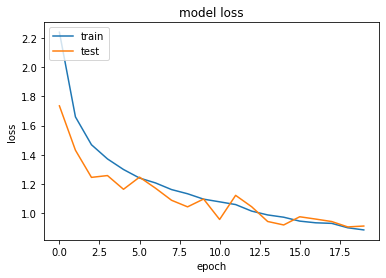

accuracy: 65.85%


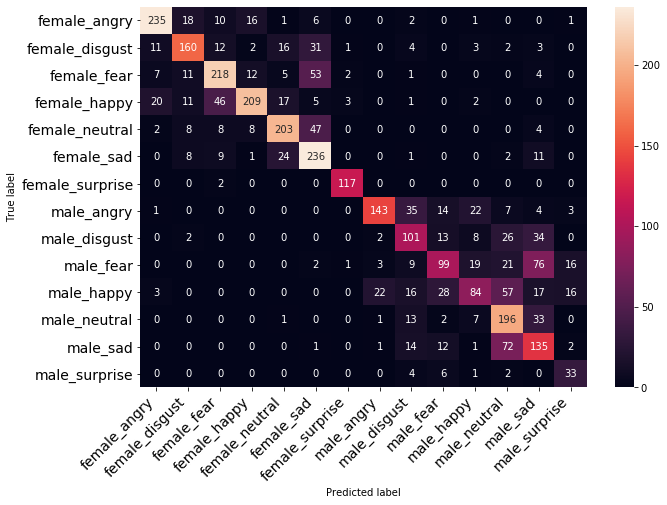

In [24]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="MFCCaug"></a>
## 3. MFCC with Augmentation 

In [25]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

100%|████████████████████████████████████████████████████████████████████████████| 13174/13174 [05:17<00:00, 41.51it/s]


In [26]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Train on 9880 samples, validate on 3294 samples
Epoch 1/20
 - 16s - loss: 2.3264 - acc: 0.2238 - val_loss: 1.8820 - val_acc: 0.3767
Epoch 2/20
 - 15s - loss: 1.8094 - acc: 0.3690 - val_loss: 1.7210 - val_acc: 0.3531
Epoch 3/20
 - 15s - loss: 1.6104 - acc: 0.4232 - val_loss: 1.6738 - val_acc: 0.4235
Epoch 4/20
 - 15s - loss: 1.5070 - acc: 0.4604 - val_loss: 1.3711 - val_acc: 0.4945
Epoch 5/20
 - 14s - loss: 1.4259 - acc: 0.4869 - val_loss: 1.3508 - val_acc: 0.4942
Epoch 6/20
 - 14s - loss: 1.3651 - acc: 0.5076 - val_loss: 1.3329 - val_acc: 0.5024
Epoch 7/20
 - 14s - loss: 1.3203 - acc: 0.5283 - val_loss: 1.5831 - val_acc: 0.4405
Epoch 8/20
 - 14s - loss: 1.2818 - acc: 0.5390 - val_loss: 1.2242 - val_acc: 0.5559
Epoch 9/20
 - 14s - loss: 1.2468 - acc: 0.5479 - val_loss: 1.0938 - val_acc: 0.5905
Epoch 10/20
 - 14s - loss: 1.2090 - acc: 0.5623 - val_loss: 1.0888 - val_acc: 0.6005
Epoch 11/20
 - 14s - loss: 1.1786 - acc: 0.5696 - val_loss: 1.0870 - val_acc: 0.5920
Epoch 12/20
 - 14s - loss:

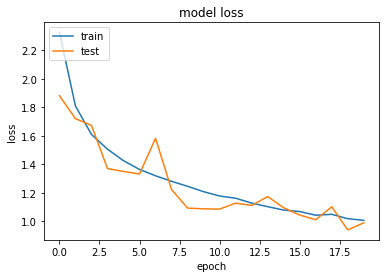

accuracy: 63.45%


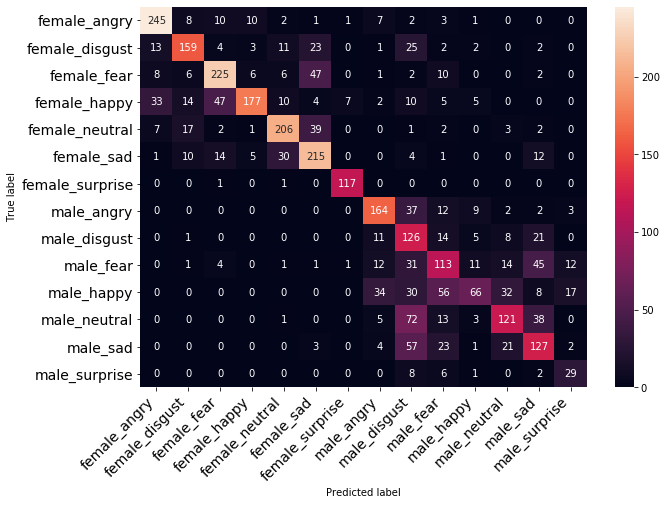

In [27]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="logmelonly"></a>
## 4. Log-melspectogram without augmentation

In [28]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
specgram = prepare_data(ref, n = n_melspec, aug = 0, mfcc = 0)

100%|████████████████████████████████████████████████████████████████████████████| 13174/13174 [05:30<00:00, 39.92it/s]


In [29]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Train on 9880 samples, validate on 3294 samples
Epoch 1/20
 - 23s - loss: 2.4145 - acc: 0.1839 - val_loss: 2.2402 - val_acc: 0.2253
Epoch 2/20
 - 22s - loss: 1.9895 - acc: 0.3091 - val_loss: 1.7217 - val_acc: 0.4016
Epoch 3/20
 - 22s - loss: 1.7246 - acc: 0.3971 - val_loss: 1.6123 - val_acc: 0.4490
Epoch 4/20
 - 22s - loss: 1.5662 - acc: 0.4440 - val_loss: 1.3865 - val_acc: 0.5164
Epoch 5/20
 - 22s - loss: 1.4569 - acc: 0.4845 - val_loss: 1.2190 - val_acc: 0.5723
Epoch 6/20
 - 22s - loss: 1.3668 - acc: 0.5092 - val_loss: 1.2002 - val_acc: 0.5704
Epoch 7/20
 - 23s - loss: 1.3165 - acc: 0.5316 - val_loss: 1.2099 - val_acc: 0.5710
Epoch 8/20
 - 23s - loss: 1.2600 - acc: 0.5461 - val_loss: 1.1191 - val_acc: 0.5859
Epoch 9/20
 - 24s - loss: 1.2283 - acc: 0.5607 - val_loss: 1.0602 - val_acc: 0.6090
Epoch 10/20
 - 23s - loss: 1.1934 - acc: 0.5711 - val_loss: 1.1421 - val_acc: 0.5856
Epoch 11/20
 - 22s - loss: 1.1552 - acc: 0.5814 - val_loss: 1.0604 - val_acc: 0.6154
Epoch 12/20
 - 23s - loss:

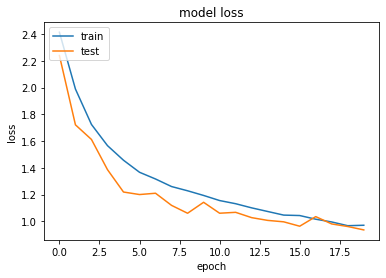

accuracy: 65.27%


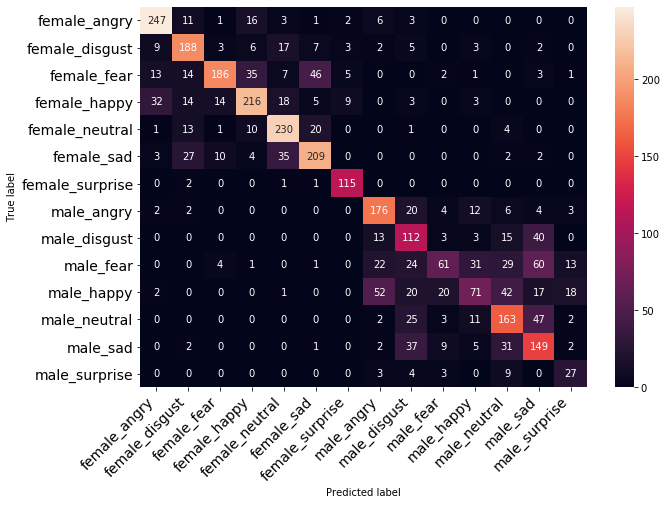

In [30]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

<a id="logmelaug"></a>
## 5. Log-melspectogram with augmentation 

In [31]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|████████████████████████████████████████████████████████████████████████████| 13174/13174 [04:33<00:00, 48.23it/s]


In [32]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Train on 9880 samples, validate on 3294 samples
Epoch 1/20
 - 23s - loss: 2.3396 - acc: 0.1982 - val_loss: 2.4942 - val_acc: 0.1949
Epoch 2/20
 - 22s - loss: 1.8728 - acc: 0.3339 - val_loss: 1.6956 - val_acc: 0.4013
Epoch 3/20
 - 22s - loss: 1.6927 - acc: 0.4059 - val_loss: 1.5042 - val_acc: 0.4560
Epoch 4/20
 - 22s - loss: 1.5931 - acc: 0.4328 - val_loss: 1.4094 - val_acc: 0.4964
Epoch 5/20
 - 22s - loss: 1.5241 - acc: 0.4582 - val_loss: 1.3529 - val_acc: 0.5352
Epoch 6/20
 - 22s - loss: 1.4363 - acc: 0.4881 - val_loss: 1.2486 - val_acc: 0.5695
Epoch 7/20
 - 22s - loss: 1.3864 - acc: 0.5022 - val_loss: 1.2343 - val_acc: 0.5653
Epoch 8/20
 - 22s - loss: 1.3515 - acc: 0.5192 - val_loss: 1.2262 - val_acc: 0.5562
Epoch 9/20
 - 22s - loss: 1.3098 - acc: 0.5364 - val_loss: 1.1262 - val_acc: 0.6005
Epoch 10/20
 - 22s - loss: 1.2753 - acc: 0.5455 - val_loss: 1.1708 - val_acc: 0.5902
Epoch 11/20
 - 22s - loss: 1.2213 - acc: 0.5603 - val_loss: 1.1651 - val_acc: 0.5847
Epoch 12/20
 - 22s - loss:

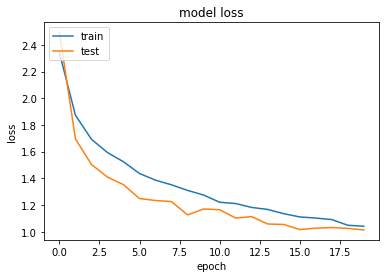

accuracy: 62.60%


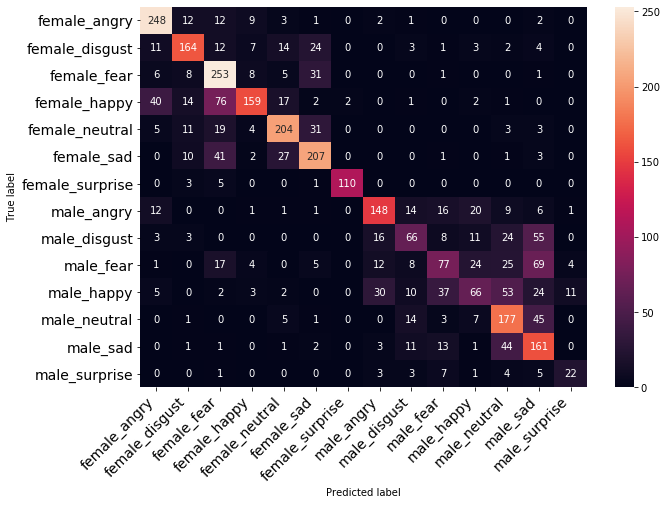

In [33]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

0.9672131147540983


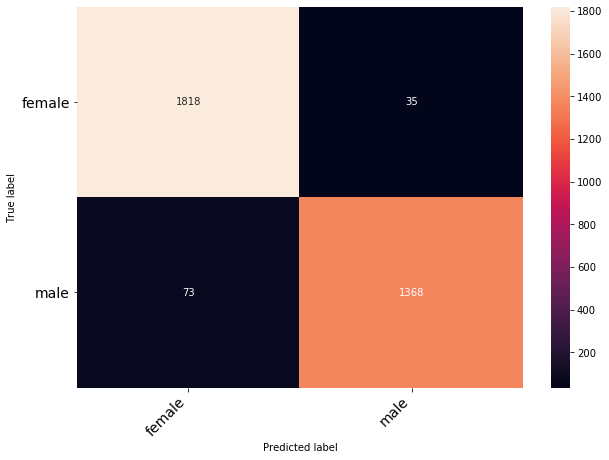

In [34]:
results.accuracy_results_gender(X_test, y_test, ref.labels.unique(), model)